In [20]:
import pandas as pd
import matplotlib
import math
import numpy as np
import statsmodels.api as sm

def linear_regression(design_matrix, target_vector): 
    return np.linalg.inv(design_matrix.transpose() @ design_matrix) @ design_matrix.transpose() @ target_vector

In [24]:
col1 = [0,1,2,3,4,5,6]
col2 = [10,11,12,13,14,15,16]
col3 = [20,21,22,23,24,25,26]
cola = [5,6,5,7]
colb = [8,4,4,5]
colc = [10,11,12,13]
test_df = pd.DataFrame({'a':cola, 'b':colb, 'c':colc})
test_df

,a,b,c
0,5,8,10
1,6,4,11
2,5,4,12
3,7,5,13


The code essentially loops through the different series, performing an AR on each one.   

Used to have a vector of parameters now have a matrix of parameters  
One row for each series

all have different coefficients but all have the same inputs, depending on the lags

**design matrix** the same for each series, but target vector will be different  

Nested loop:
- outer loop iterates through commodities
- inner loop performs the AR on each commodity




In [26]:
def train_var(df, order):
    param_rows = []
    # dmnum = 0
    # loop through each series, doing AR on each one
    for column in df.columns:
        print('col', column)
        # TARGET VECTOR
        # skip first (order) p values
        target_vector = np.array( df[ column ][ order : ] )
        print('TARGET VECTOR: ', target_vector)
        
        lagged_values = []
        # make design matrices
        for i in range(len(df[column]) - order):
            # start with 0's
            design_row = np.zeros(0)
            
            for param_col in df.columns:
                design_row = np.append(design_row, df[param_col][i:i+order])
                print('design row: ', design_row) 
            # get each row of lagged values for order 2 = 2 values from each series
            lagged_values.append(design_row)
        design_matrix = np.array(lagged_values)
        print('DESIGN MATRIX:', design_matrix)
        
        # param_rows.append(linear_regression(design_matrix, target_vector))
    return np.array(param_rows)
    

train_var(test_df, 2)

col a
TARGET VECTOR:  [5 7]
design row:  [5. 6.]
design row:  [5. 6. 8. 4.]
design row:  [ 5.  6.  8.  4. 10. 11.]
design row:  [6. 5.]
design row:  [6. 5. 4. 4.]
design row:  [ 6.  5.  4.  4. 11. 12.]
DESIGN MATRIX: [[ 5.  6.  8.  4. 10. 11.]
 [ 6.  5.  4.  4. 11. 12.]]
col b
TARGET VECTOR:  [4 5]
design row:  [5. 6.]
design row:  [5. 6. 8. 4.]
design row:  [ 5.  6.  8.  4. 10. 11.]
design row:  [6. 5.]
design row:  [6. 5. 4. 4.]
design row:  [ 6.  5.  4.  4. 11. 12.]
DESIGN MATRIX: [[ 5.  6.  8.  4. 10. 11.]
 [ 6.  5.  4.  4. 11. 12.]]
col c
TARGET VECTOR:  [12 13]
design row:  [5. 6.]
design row:  [5. 6. 8. 4.]
design row:  [ 5.  6.  8.  4. 10. 11.]
design row:  [6. 5.]
design row:  [6. 5. 4. 4.]
design row:  [ 6.  5.  4.  4. 11. 12.]
DESIGN MATRIX: [[ 5.  6.  8.  4. 10. 11.]
 [ 6.  5.  4.  4. 11. 12.]]


array([], dtype=float64)

## Real Data
British GDP vs Job Vacancies
Couldn't find data
Imported different ones

In [ ]:
df = pd.read_csv('./data/M2SLMoneyStock.csv')
df2 = pd.read_csv('./data/PCEPersonalSpending.csv')


In [ ]:
df = df.set_index('Date').join(df2.set_index('Date'))

In [ ]:
order = 4
df_test = df[100:116]

var_params = train_var(df,order)
var_params

array([[-0.08678108,  0.03802285, -0.09820925,  1.14791166,  0.04420334,
         0.05015833,  0.02024647, -0.11148272],
       [ 0.08357758,  0.00364851, -0.2489073 ,  0.15897149, -0.11556855,
        -0.04850428,  0.12608193,  1.04256798]])

Have 2 rows = 1 for each series
Each row has 6 parameters = 2 series * 3 order = 6


## Prediction



In [ ]:
def predict_var(df, params):
    # compute the order of the VAR
    # divide cols (k*p) params by rows (p)
    order = params.shape[1] // params.shape[0]

    # create empty DF
    results = pd.DataFrame() 

    # outer loop - everything within it done to do predictions for all cols (series)
    for column_num, column in enumerate(df.columns):
        # set first order numbers to nan as can't predict
        predicted_values = [math.nan]*order

        # inner loop - predict for each row in column - order
        for i in range(len(df[column]) - order):
            # start with row of 0's
            lags = np.zeros(0)
            # get order amount of lag values from the series column
            for param_column in df.columns:
                # should get order # of values for each of the columns
                lags = np.append(lags, df[param_column][i : i + order])
                if i < 3:
                    print('take lags', lags, 'from ', param_column, 'to predict', column,)
            # Get predictions: combine lags and coefficients by dot product
            # params gotten from training model - taken as input at top
            predicted_values.append(np.dot(lags, params[column_num, :]))
            # print(params[column_num, :])
        # add to results df
        results[column] = predicted_values
    return results


predictions = predict_var(df, var_params)
predictions.head(10)

take lags [3492.4 3489.9 3491.1 3499.2] from  Money to predict Money
take lags [3492.4 3489.9 3491.1 3499.2 4851.2 4850.8 4885.4 4890.2] from  Spending to predict Money
take lags [3489.9 3491.1 3499.2 3524.2] from  Money to predict Money
take lags [3489.9 3491.1 3499.2 3524.2 4850.8 4885.4 4890.2 4933.1] from  Spending to predict Money
take lags [3491.1 3499.2 3524.2 3548.9] from  Money to predict Money
take lags [3491.1 3499.2 3524.2 3548.9 4885.4 4890.2 4933.1 4977.5] from  Spending to predict Money
take lags [3492.4 3489.9 3491.1 3499.2] from  Money to predict Spending
take lags [3492.4 3489.9 3491.1 3499.2 4851.2 4850.8 4885.4 4890.2] from  Spending to predict Spending
take lags [3489.9 3491.1 3499.2 3524.2] from  Money to predict Spending
take lags [3489.9 3491.1 3499.2 3524.2 4850.8 4885.4 4890.2 4933.1] from  Spending to predict Spending
take lags [3491.1 3499.2 3524.2 3548.9] from  Money to predict Spending
take lags [3491.1 3499.2 3524.2 3548.9 4885.4 4890.2 4933.1 4977.5] fro

,Money,Spending
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,3515.022509,4910.327952
5,3540.219758,4955.780864
6,3564.010729,5001.082064
7,3587.145706,4993.994947
8,3608.955875,5023.565761
9,3621.044715,5037.899100


In [ ]:
def rmse(predicted, actual):
    # print(predicted, actual)1
    diffs = predicted - actual
    # print(diffs)
    return math.sqrt(np.mean(diffs ** 2))
    

VAR(4) Spending rmse 33.79412621383513
VAR(4) Money rmse 25.54172842969896


<AxesSubplot:>

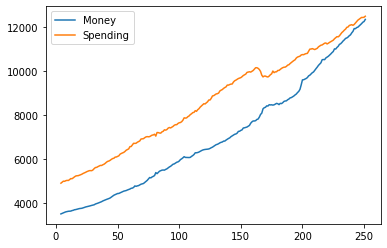

In [ ]:
new_df = df.copy()
new_df = new_df.reset_index()
new_df = new_df.drop(['Date'], axis=1)
# new_df['Pred_Money'] = predictions['Money']
# new_df['Pred_Spending'] = predictions['Spending']

print("VAR(4) Spending rmse", rmse(new_df['Spending'], predictions['Spending']))
print("VAR(4) Money rmse", rmse(new_df['Money'], predictions['Money']))


predictions.plot()

<AxesSubplot:>

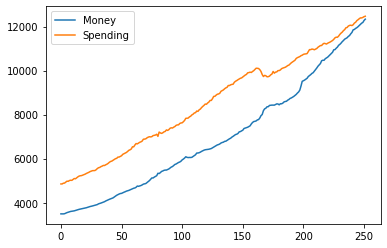

In [ ]:
new_df.plot()

### Plot differences
This is the error, want them to hover around 0  
Can see here the error starts to trend for both of them

<AxesSubplot:>

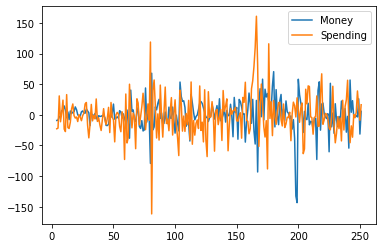

In [ ]:
(predictions - new_df).plot()

## Compare results to an AR model alone

In [ ]:
df_spending = new_df['Spending']
df_money = new_df['Money']

In [ ]:
def train_ar(values, order):
    target_vector = np.array(values[order:])
    lagged_values = []
    for i in range(len(values) - order):
        lagged_values.append(values[i:i+order])
    design_matrix = np.array(lagged_values)
    return linear_regression(design_matrix, target_vector)

def predict(coeffs, data):
    predicted_values = [math.nan] * len(coeffs)
    for i in range(len(coeffs), len(data)):
        predicted_values.append(np.dot(coeffs, data[i-len(coeffs):i]))
    return np.array(predicted_values)

In [ ]:
spending_predict_ar4 = predict(train_ar(new_df['Spending'], 4), new_df['Spending'])
money_predict_ar4 = predict(train_ar(new_df['Money'], 4), new_df['Money'])
print("VAR(4) Spending rmse", rmse(new_df['Spending'], predictions['Spending']))
print('AR(4) Spending model rmse', rmse(spending_predict_ar4, new_df['Spending']))
print("VAR(4) Money rmse", rmse(new_df['Money'], predictions['Money']))
print('AR(4) Money model rmse', rmse(money_predict_ar4, new_df['Money']))

VAR(4) Spending rmse 33.79412621383513
AR(4) Spending model rmse 34.22652521137028
VAR(4) Money rmse 25.54172842969896
AR(4) Money model rmse 26.09486639534869


In this case VAR(4) model wins out

## Using Stats Models

Using AR model first

In [ ]:
import statsmodels.api as sm
spending_model = sm.tsa.AutoReg(new_df['Spending'], lags=4, trend='n').fit()
money_model = sm.tsa.AutoReg(new_df['Money'], lags=4, trend='n').fit()

print('AR(4) spending model rmse', rmse(spending_model.predict(), new_df['Spending']))
print('AR(4) money model rmse', rmse(money_model.predict(), new_df['Money']))

AR(4) spending model rmse 34.22652521137028
AR(4) money model rmse 26.094866395348724


In [ ]:
var_model = sm.tsa.VAR(new_df[['Spending', 'Money']]).fit(4,trend='n')

print('VAR model SPENDING rmse', rmse(var_model.resid['Spending'],0))
print('VAR model Money rmse', rmse(var_model.resid['Money'],0))

var_model.params

VAR model SPENDING rmse 33.79412621383522
VAR model Money rmse 25.541728429698818


,Spending,Money
L1.Spending,1.042568,-0.111483
L1.Money,0.158971,1.147912
L2.Spending,0.126082,0.020246
L2.Money,-0.248907,-0.098209
L3.Spending,-0.048504,0.050158
L3.Money,0.003649,0.038023
L4.Spending,-0.115569,0.044203
L4.Money,0.083578,-0.086781
